<a href="https://colab.research.google.com/github/Sievv/Modifications-AMPs-from-KP-ML/blob/main/3model_test_mutation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 78.6 MB/s eta 0:00:00


**1. Using Input Box in Colab for Sequence Input::



In [10]:
import pandas as pd
import numpy as np
import joblib
from Bio.SeqUtils import molecular_weight
from Bio.Seq import Seq
import ipywidgets as widgets
from IPython.display import display

# Load trained models
rf_model = joblib.load('/content/drive/MyDrive/KP/KP imbalance/Random_Forest_fixed_model.pkl')
gb_model = joblib.load('/content/drive/MyDrive/KP/KP imbalance/Gradient_Boosting_fixed_model.pkl')
ada_model = joblib.load('/content/drive/MyDrive/KP/KP imbalance/AdaBoost_fixed_model.pkl')

# Feature calculation functions
def calculate_charge(sequence):
    positive = sequence.count('K') + sequence.count('R') + sequence.count('H')
    negative = sequence.count('D') + sequence.count('E')
    return positive - negative

def calculate_hydrophobicity(sequence):
    hydrophobic_residues = 'AVILMFYW'
    return sum(sequence.count(aa) for aa in hydrophobic_residues)

def calculate_molecular_weight(sequence):
    return molecular_weight(Seq(sequence), seq_type='protein')

def calculate_number_of_cysteines(sequence):
    return sequence.count('C')

def calculate_number_of_disulfide_bridges(sequence):
    return calculate_number_of_cysteines(sequence) // 2

def calculate_isoelectric_point(sequence):
    pKa_acidic = {'D':3.9, 'E':4.25}
    pKa_basic = {'K':10.5, 'R':12.5, 'H':6.0}
    acidic_count = sum(sequence.count(aa) for aa in pKa_acidic)
    basic_count = sum(sequence.count(aa) for aa in pKa_basic)
    if acidic_count + basic_count == 0:
        return 7.0
    total_charge_pI = sum(pKa_acidic[aa]*sequence.count(aa) for aa in pKa_acidic) + sum(pKa_basic[aa]*sequence.count(aa) for aa in pKa_basic)
    return total_charge_pI / (acidic_count + basic_count)

def amino_acid_composition(sequence):
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    total = len(sequence)
    return {aa: (sequence.count(aa) / total * 100 if total > 0 else 0) for aa in amino_acids}

def secondary_structure_features(sequence):
    helix_aa = 'ALIVMFYW'
    sheet_aa = 'FYW'
    turn_aa = 'GP'
    helix = sum(sequence.count(aa) for aa in helix_aa)
    sheet = sum(sequence.count(aa) for aa in sheet_aa)
    turn = sum(sequence.count(aa) for aa in turn_aa)
    flexibility = helix / len(sequence) if len(sequence) > 0 else 0
    return helix, turn, sheet, flexibility

# Load feature columns from training set or fallback list
X_train_cols = ['Length', 'Charge', 'Hydrophobicity', 'Molecular_Weight',
                'Number_of_Cysteines', 'Number_of_Disulfide_Bridges', 'Isoelectric_Point',
                'Helix', 'Turn', 'Sheet', 'Flexibility'] + list('ACDEFGHIKLMNPQRSTVWY')
feature_columns_for_prediction = X_train_cols

# Helper function to calculate all features for a sequence
def calc_features_dict(seq):
    features = {
        'Length': len(seq),
        'Charge': calculate_charge(seq),
        'Hydrophobicity': calculate_hydrophobicity(seq),
        'Molecular_Weight': calculate_molecular_weight(seq),
        'Number_of_Cysteines': calculate_number_of_cysteines(seq),
        'Number_of_Disulfide_Bridges': calculate_number_of_disulfide_bridges(seq),
        'Isoelectric_Point': calculate_isoelectric_point(seq),
    }
    features.update(amino_acid_composition(seq))
    helix, turn, sheet, flexibility = secondary_structure_features(seq)
    features.update({'Helix': helix, 'Turn': turn, 'Sheet': sheet, 'Flexibility': flexibility})
    return features

# Automated classification function
def classify_peptide(sequence):
    # Step 1: Extract features for the input sequence
    features = calc_features_dict(sequence)
    feature_vector = [features.get(col, 0) for col in feature_columns_for_prediction]

    # Step 2: Predict using all models (RF, GB, AdaBoost)
    rf_prob = rf_model.predict_proba(np.array(feature_vector).reshape(1, -1))[:,1][0]
    gb_prob = gb_model.predict_proba(np.array(feature_vector).reshape(1, -1))[:,1][0]
    ada_prob = ada_model.predict_proba(np.array(feature_vector).reshape(1, -1))[:,1][0]

    # Step 3: Define criteria for active peptide
    active = rf_prob >= 0.5 and gb_prob >= 0.5 and ada_prob >= 0.5

    # Step 4: Return results
    return {
        'Sequence': sequence,
        'RF_Prob': rf_prob,
        'GB_Prob': gb_prob,
        'Ada_Prob': ada_prob,
        'Active': active
    }

# Function that handles the user input and displays the result
def on_button_click(b):
    sequence_input = sequence_text.value  # Get the sequence input
    result = classify_peptide(sequence_input)

    # Display results
    output_text.value = f"Results for Sequence: {sequence_input}\n" + \
                        f"RF Probability: {result['RF_Prob']}\n" + \
                        f"GB Probability: {result['GB_Prob']}\n" + \
                        f"AdaBoost Probability: {result['Ada_Prob']}\n" + \
                        f"Is Active: {result['Active']}"

# Create input box for peptide sequence
sequence_text = widgets.Text(
    description="Sequence: ",
    placeholder="Enter sequence here (no spaces)"
)

# Create output area for result display
output_text = widgets.Textarea(
    description="Prediction Results: ",
    disabled=True,
    layout=widgets.Layout(width="500px", height="200px")
)

# Create button to trigger classification
button = widgets.Button(description="Classify Peptide")
button.on_click(on_button_click)

# Display input box, button, and output
display(sequence_text, button, output_text)


Text(value='', description='Sequence: ', placeholder='Enter sequence here (no spaces)')

Button(description='Classify Peptide', style=ButtonStyle())

Textarea(value='', description='Prediction Results: ', disabled=True, layout=Layout(height='200px', width='500…

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


In [4]:
!pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=10cc52d1a43ff91d86b0b4e4520b84a35867880da20ad2add410e7cdffe37f71
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


GOOD LONG

Text(value='', description='Sequence: ', placeholder='Enter sequence here (no spaces)')

Button(description='Classify Peptide and Explain', style=ButtonStyle())

Textarea(value='', description='Prediction Results and Explanation: ', disabled=True, layout=Layout(height='40…

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


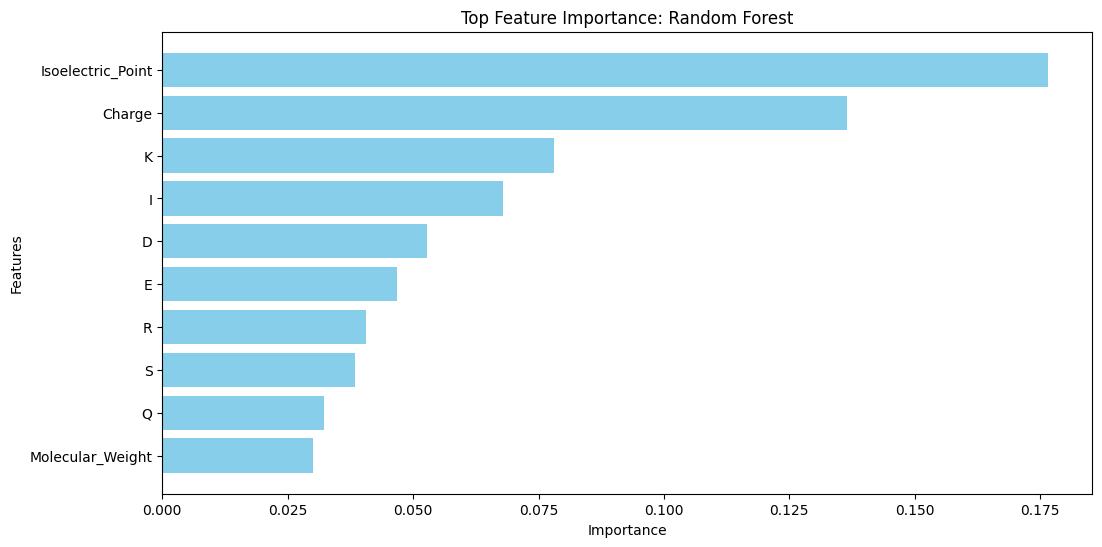

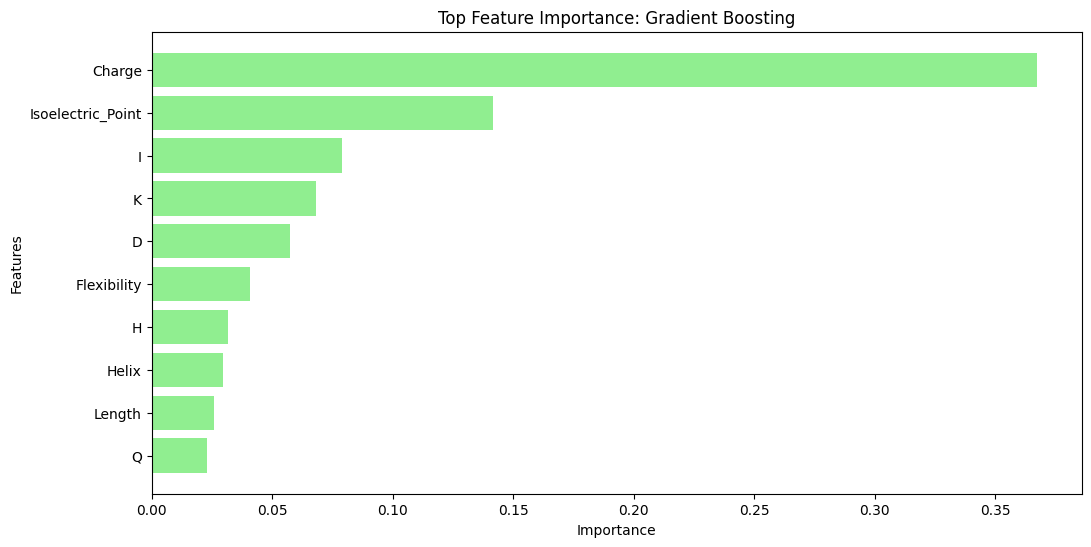

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [18]:
import numpy as np
import joblib
import lime
from lime.lime_tabular import LimeTabularExplainer
from Bio.SeqUtils import molecular_weight
from Bio.Seq import Seq
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt


# Load trained models
rf_model = joblib.load('/content/drive/MyDrive/KP/KP imbalance/Random_Forest_fixed_model.pkl')
gb_model = joblib.load('/content/drive/MyDrive/KP/KP imbalance/Gradient_Boosting_fixed_model.pkl')
ada_model = joblib.load('/content/drive/MyDrive/KP/KP imbalance/AdaBoost_fixed_model.pkl')

# Feature calculation functions
def calculate_charge(sequence):
    positive = sequence.count('K') + sequence.count('R') + sequence.count('H')
    negative = sequence.count('D') + sequence.count('E')
    return positive - negative

def calculate_hydrophobicity(sequence):
    hydrophobic_residues = 'AVILMFYW'
    return sum(sequence.count(aa) for aa in hydrophobic_residues)

def calculate_molecular_weight(sequence):
    return molecular_weight(Seq(sequence), seq_type='protein')

def calculate_number_of_cysteines(sequence):
    return sequence.count('C')

def calculate_number_of_disulfide_bridges(sequence):
    return calculate_number_of_cysteines(sequence) // 2

def calculate_isoelectric_point(sequence):
    pKa_acidic = {'D':3.9, 'E':4.25}
    pKa_basic = {'K':10.5, 'R':12.5, 'H':6.0}
    acidic_count = sum(sequence.count(aa) for aa in pKa_acidic)
    basic_count = sum(sequence.count(aa) for aa in pKa_basic)
    if acidic_count + basic_count == 0:
        return 7.0
    total_charge_pI = sum(pKa_acidic[aa]*sequence.count(aa) for aa in pKa_acidic) + sum(pKa_basic[aa]*sequence.count(aa) for aa in pKa_basic)
    return total_charge_pI / (acidic_count + basic_count)

def amino_acid_composition(sequence):
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    total = len(sequence)
    return {aa: (sequence.count(aa) / total * 100 if total > 0 else 0) for aa in amino_acids}

def secondary_structure_features(sequence):
    helix_aa = 'ALIVMFYW'
    sheet_aa = 'FYW'
    turn_aa = 'GP'
    helix = sum(sequence.count(aa) for aa in helix_aa)
    sheet = sum(sequence.count(aa) for aa in sheet_aa)
    turn = sum(sequence.count(aa) for aa in turn_aa)
    flexibility = helix / len(sequence) if len(sequence) > 0 else 0
    return helix, turn, sheet, flexibility

# Load feature columns from training set or fallback list
X_train_cols = ['Length', 'Charge', 'Hydrophobicity', 'Molecular_Weight',
                'Number_of_Cysteines', 'Number_of_Disulfide_Bridges', 'Isoelectric_Point',
                'Helix', 'Turn', 'Sheet', 'Flexibility'] + list('ACDEFGHIKLMNPQRSTVWY')
feature_columns_for_prediction = X_train_cols

# Helper function to calculate all features for a sequence
def calc_features_dict(seq):
    features = {
        'Length': len(seq),
        'Charge': calculate_charge(seq),
        'Hydrophobicity': calculate_hydrophobicity(seq),
        'Molecular_Weight': calculate_molecular_weight(seq),
        'Number_of_Cysteines': calculate_number_of_cysteines(seq),
        'Number_of_Disulfide_Bridges': calculate_number_of_disulfide_bridges(seq),
        'Isoelectric_Point': calculate_isoelectric_point(seq),
    }
    features.update(amino_acid_composition(seq))
    helix, turn, sheet, flexibility = secondary_structure_features(seq)
    features.update({'Helix': helix, 'Turn': turn, 'Sheet': sheet, 'Flexibility': flexibility})
    return features

# Automated classification function
def classify_peptide(sequence):
    # Step 1: Extract features for the input sequence
    features = calc_features_dict(sequence)
    feature_vector = [features.get(col, 0) for col in feature_columns_for_prediction]

    # Step 2: Predict using all models (RF, GB, AdaBoost)
    rf_prob = rf_model.predict_proba(np.array(feature_vector).reshape(1, -1))[:,1][0]
    gb_prob = gb_model.predict_proba(np.array(feature_vector).reshape(1, -1))[:,1][0]
    ada_prob = ada_model.predict_proba(np.array(feature_vector).reshape(1, -1))[:,1][0]

    # Step 3: Define criteria for active peptide
    active = rf_prob >= 0.5 and gb_prob >= 0.5 and ada_prob >= 0.5

    # Step 4: Return results
    # Add feature values and importance to the result dictionary
    feature_values = {col: features.get(col, 0) for col in feature_columns_for_prediction}
    # Assuming models have feature_importances_ attribute
    # Note: AdaBoost does not have feature_importances_ directly, using attribute importances_
    rf_importance = dict(zip(feature_columns_for_prediction, rf_model.feature_importances_))
    gb_importance = dict(zip(feature_columns_for_prediction, gb_model.feature_importances_))
    # Use .feature_importances_ if available, otherwise .estimators_[0].feature_importances_ (common for ensemble) or .importances_
    # Using the most common attribute, adjust if your specific AdaBoost model uses a different one
    # Assuming AdaBoost model also has feature_importances_ similar to RandomForest or GradientBoosting
    try:
        ada_importance = dict(zip(feature_columns_for_prediction, ada_model.feature_importances_))
    except AttributeError:
        # Fallback or handle specific AdaBoost model structure if needed
        ada_importance = {"Ada Importance not available directly": 0} # Placeholder


    return {
        'Sequence': sequence,
        'RF_Prob': rf_prob,
        'GB_Prob': gb_prob,
        'Ada_Prob': ada_prob,
        'Active': active,
        'Features': feature_values,
        'Importance': {
            'RF Importance': rf_importance,
            'GB Importance': gb_importance,
            'Ada Importance': ada_importance # Included Ada importance
        }
    }

# Function to prepare features for LIME
def prepare_features(seq):
    features = calc_features_dict(seq)
    feature_vector = np.array([features.get(col, 0) for col in feature_columns_for_prediction])
    return feature_vector

# LIME Explainer
def explain_with_lime(sequence):
    # Prepare feature vector for input sequence
    feature_vector = prepare_features(sequence).reshape(1, -1)

    # LIME Tabular Explainer
    # Ensure the training data is representative and has the same feature order
    # Using example data; for production, use a subset of your actual training data
    # to build the explainer's background distribution.
    example_sequences = ["KKIRVRLSA", "SGLGCNVLRRY"] # Replace with a sample from your actual training data
    training_data_for_lime = np.array([prepare_features(seq) for seq in example_sequences])

    explainer = LimeTabularExplainer(
        training_data=training_data_for_lime,
        feature_names=feature_columns_for_prediction,
        class_names=['Inactive', 'Active'],
        mode='classification'
    )

    # Explain prediction for the given sequence
    # Explain for class 1 (Active)
    explanation = explainer.explain_instance(
        data_row=feature_vector[0],
        predict_fn=rf_model.predict_proba, # Using RF model for LIME explanation as in original code
        num_features=10 # You can adjust the number of features to display
    )

    # Show explanation
    explanation.show_in_notebook()

# Plot Feature Explanation (why active/inactive)
def plot_feature_explanation(result):
    # Only plot RF and GB importance as AdaBoost feature importance calculation can vary
    importance = result['Importance']

    rf_features = importance['RF Importance']
    gb_features = importance['GB Importance']

    # Sort by importance and take top N for clarity
    N = 10 # Display top 10 features
    rf_sorted = sorted(rf_features.items(), key=lambda x: x[1], reverse=True)[:N]
    gb_sorted = sorted(gb_features.items(), key=lambda x: x[1], reverse=True)[:N]

    rf_labels, rf_vals = zip(*rf_sorted)
    gb_labels, gb_vals = zip(*gb_sorted)

    # Plot RF importance
    plt.figure(figsize=(12, 6))
    # Reverse the order for horizontal bar plot for better readability (highest at the top)
    plt.barh(rf_labels[::-1], rf_vals[::-1], color='skyblue', label='Random Forest')
    plt.title("Top Feature Importance: Random Forest")
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.show()

    # Plot GB importance
    plt.figure(figsize=(12, 6))
    # Reverse the order for horizontal bar plot
    plt.barh(gb_labels[::-1], gb_vals[::-1], color='lightgreen', label='Gradient Boosting')
    plt.title("Top Feature Importance: Gradient Boosting")
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.show()

# Function that handles the user input and displays the result and explanation
def on_button_click(b):
    sequence_input = sequence_text.value  # Get the sequence input
    if not sequence_input:
        output_text.value = "Please enter a peptide sequence."
        return

    try:
        result = classify_peptide(sequence_input)

        # Display results
        output_text.value = f"Results for Sequence: {sequence_input}\n" + \
                            f"RF Probability: {result['RF_Prob']:.4f}\n" + \
                            f"GB Probability: {result['GB_Prob']:.4f}\n" + \
                            f"AdaBoost Probability: {result['Ada_Prob']:.4f}\n" + \
                            f"Is Active: {result['Active']}"

        # Plotting which features influenced the classification (RF and GB)
        plot_feature_explanation(result)

        # Show LIME explanation
        explain_with_lime(sequence_input)

    except Exception as e:
        output_text.value = f"An error occurred: {e}"


# Create input box for peptide sequence
sequence_text = widgets.Text(
    description="Sequence: ",
    placeholder="Enter sequence here (no spaces)"
)

# Create output area for result display
output_text = widgets.Textarea(
    description="Prediction Results and Explanation: ",
    disabled=True,
    layout=widgets.Layout(width="600px", height="400px")
)

# Create button to trigger classification
button = widgets.Button(description="Classify Peptide and Explain")
button.on_click(on_button_click)

# Display input box, button, and output
display(sequence_text, button, output_text)

Text(value='', description='Sequence: ', placeholder='Enter sequence here (no spaces)')

Button(description='Classify Peptide', style=ButtonStyle())

Textarea(value='', description='Prediction Results: ', disabled=True, layout=Layout(height='300px', width='500…

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


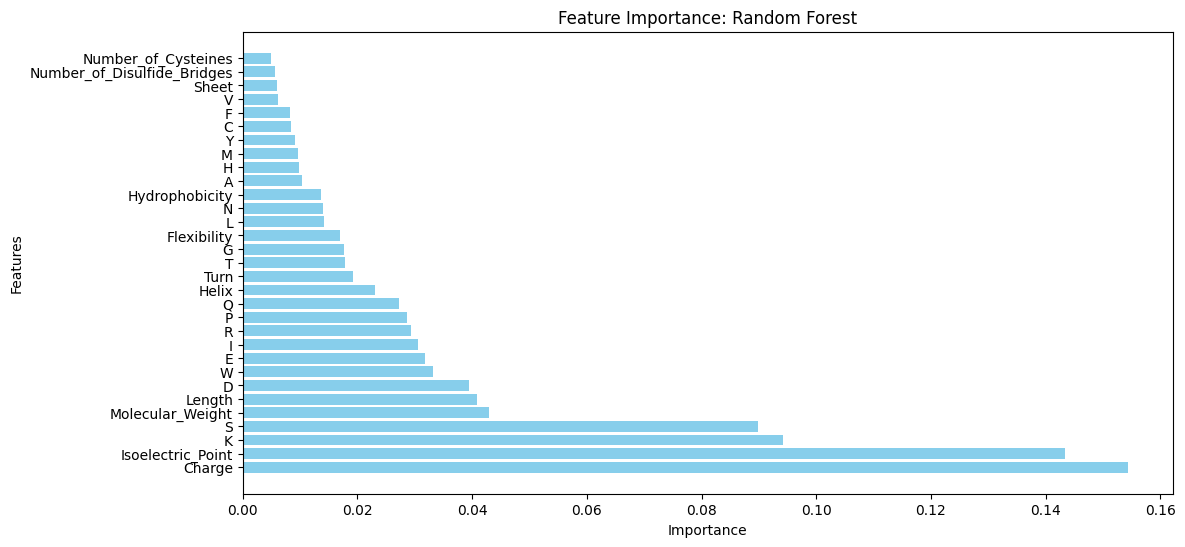

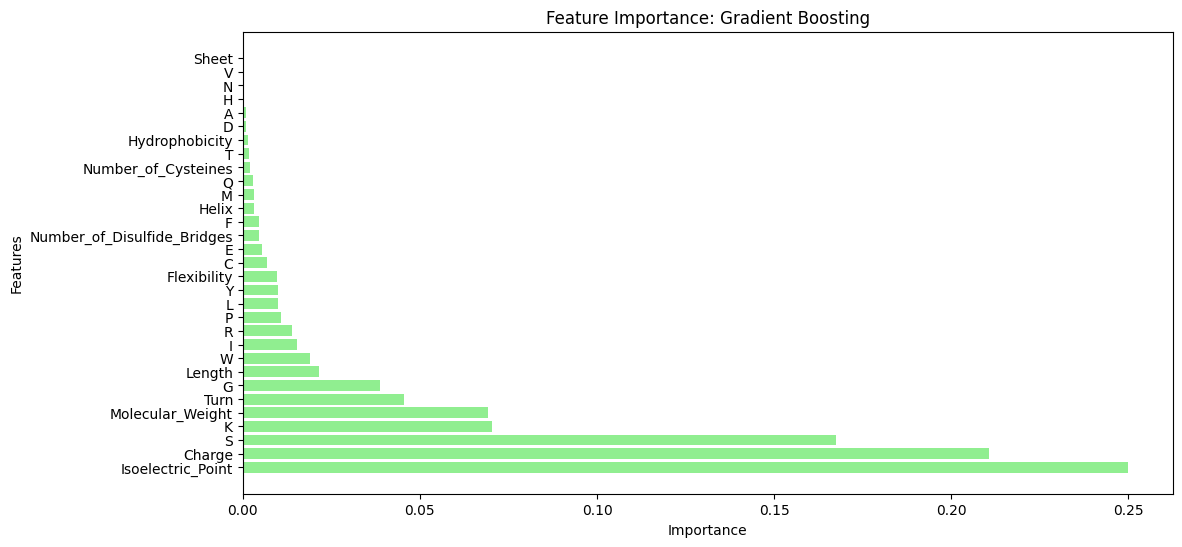

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [17]:
import numpy as np
import joblib
import lime
from lime.lime_tabular import LimeTabularExplainer
from Bio.SeqUtils import molecular_weight
from Bio.Seq import Seq
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

# Load trained models
rf_model = joblib.load('/content/drive/MyDrive/PS/PS imbalance/pretrain_random_forest_model.pkl')
gb_model = joblib.load('/content/drive/MyDrive/PS/PS imbalance/pretrain_gradient_boosting_model.pkl')
ada_model = joblib.load('/content/drive/MyDrive/PS/PS imbalance/pretrain_adaboost_model.pkl')

# Feature calculation functions
def calculate_charge(sequence):
    positive = sequence.count('K') + sequence.count('R') + sequence.count('H')
    negative = sequence.count('D') + sequence.count('E')
    return positive - negative

def calculate_hydrophobicity(sequence):
    hydrophobic_residues = 'AVILMFYW'
    return sum(sequence.count(aa) for aa in hydrophobic_residues)

def calculate_molecular_weight(sequence):
    return molecular_weight(Seq(sequence), seq_type='protein')

def calculate_number_of_cysteines(sequence):
    return sequence.count('C')

def calculate_number_of_disulfide_bridges(sequence):
    return calculate_number_of_cysteines(sequence) // 2

def calculate_isoelectric_point(sequence):
    pKa_acidic = {'D':3.9, 'E':4.25}
    pKa_basic = {'K':10.5, 'R':12.5, 'H':6.0}
    acidic_count = sum(sequence.count(aa) for aa in pKa_acidic)
    basic_count = sum(sequence.count(aa) for aa in pKa_basic)
    if acidic_count + basic_count == 0:
        return 7.0
    total_charge_pI = sum(pKa_acidic[aa]*sequence.count(aa) for aa in pKa_acidic) + sum(pKa_basic[aa]*sequence.count(aa) for aa in pKa_basic)
    return total_charge_pI / (acidic_count + basic_count)

def amino_acid_composition(sequence):
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    total = len(sequence)
    return {aa: (sequence.count(aa) / total * 100 if total > 0 else 0) for aa in amino_acids}

def secondary_structure_features(sequence):
    helix_aa = 'ALIVMFYW'
    sheet_aa = 'FYW'
    turn_aa = 'GP'
    helix = sum(sequence.count(aa) for aa in helix_aa)
    sheet = sum(sequence.count(aa) for aa in sheet_aa)
    turn = sum(sequence.count(aa) for aa in turn_aa)
    flexibility = helix / len(sequence) if len(sequence) > 0 else 0
    return helix, turn, sheet, flexibility

# Load feature columns from training set or fallback list
X_train_cols = ['Length', 'Charge', 'Hydrophobicity', 'Molecular_Weight',
                'Number_of_Cysteines', 'Number_of_Disulfide_Bridges', 'Isoelectric_Point',
                'Helix', 'Turn', 'Sheet', 'Flexibility'] + list('ACDEFGHIKLMNPQRSTVWY')
feature_columns_for_prediction = X_train_cols

# Helper function to calculate all features for a sequence
def calc_features_dict(seq):
    features = {
        'Length': len(seq),
        'Charge': calculate_charge(seq),
        'Hydrophobicity': calculate_hydrophobicity(seq),
        'Molecular_Weight': calculate_molecular_weight(seq),
        'Number_of_Cysteines': calculate_number_of_cysteines(seq),
        'Number_of_Disulfide_Bridges': calculate_number_of_disulfide_bridges(seq),
        'Isoelectric_Point': calculate_isoelectric_point(seq),
    }
    features.update(amino_acid_composition(seq))
    helix, turn, sheet, flexibility = secondary_structure_features(seq)
    features.update({'Helix': helix, 'Turn': turn, 'Sheet': sheet, 'Flexibility': flexibility})
    return features

# Function to prepare features for LIME
def prepare_features(seq):
    features = calc_features_dict(seq)
    feature_vector = np.array([features.get(col, 0) for col in feature_columns_for_prediction])
    return feature_vector

# LIME Explainer
def explain_with_lime(sequence):
    # Prepare feature vector for input sequence
    feature_vector = prepare_features(sequence).reshape(1, -1)

    # LIME Tabular Explainer
    explainer = LimeTabularExplainer(
        training_data=np.array([prepare_features(seq) for seq in ["KKIRVRLSA", "SGLGCNVLRRY"]]), # Example training data
        feature_names=feature_columns_for_prediction,
        class_names=['Inactive', 'Active'],
        mode='classification'
    )

    # Explain prediction for the given sequence
    explanation = explainer.explain_instance(feature_vector[0], rf_model.predict_proba)

    # Show explanation
    explanation.show_in_notebook()

# Function to classify peptide and provide LIME explanation
def on_button_click(b):
    sequence_input = sequence_text.value  # Get the sequence input
    result = classify_peptide(sequence_input)

    # Display results
    output_text.value = f"Results for Sequence: {sequence_input}\n" + \
                        f"RF Probability: {result['RF_Prob']}\n" + \
                        f"GB Probability: {result['GB_Prob']}\n" + \
                        f"AdaBoost Probability: {result['Ada_Prob']}\n" + \
                        f"Is Active: {result['Active']}\n\n" + \
                        f"Feature Importance (Random Forest):\n{result['Importance']['RF Importance']}\n\n" + \
                        f"Feature Importance (Gradient Boosting):\n{result['Importance']['GB Importance']}\n\n" + \
                        f"Feature Values (for explanation):\n{result['Features']}"

    # Plotting which features influenced the classification
    plot_feature_explanation(result)

    # Show LIME explanation
    explain_with_lime(sequence_input)

# Plot Feature Explanation (why active/inactive)
def plot_feature_explanation(result):
    features = result['Features']
    importance = result['Importance']

    # Plot the top features with the highest importance
    rf_features = importance['RF Importance']
    gb_features = importance['GB Importance']

    # Sort by importance
    rf_sorted = sorted(rf_features.items(), key=lambda x: x[1], reverse=True)
    gb_sorted = sorted(gb_features.items(), key=lambda x: x[1], reverse=True)

    rf_labels, rf_vals = zip(*rf_sorted)
    gb_labels, gb_vals = zip(*gb_sorted)

    # Plot RF importance
    plt.figure(figsize=(12, 6))
    plt.barh(rf_labels, rf_vals, color='skyblue', label='Random Forest')
    plt.title("Feature Importance: Random Forest")
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.show()

    # Plot GB importance
    plt.figure(figsize=(12, 6))
    plt.barh(gb_labels, gb_vals, color='lightgreen', label='Gradient Boosting')
    plt.title("Feature Importance: Gradient Boosting")
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.show()

# Create input box for peptide sequence
sequence_text = widgets.Text(
    description="Sequence: ",
    placeholder="Enter sequence here (no spaces)"
)

# Create output area for result display
output_text = widgets.Textarea(
    description="Prediction Results: ",
    disabled=True,
    layout=widgets.Layout(width="500px", height="300px")
)

# Create button to trigger classification
button = widgets.Button(description="Classify Peptide")
button.on_click(on_button_click)

# Display input box, button, and output
display(sequence_text, button, output_text)


Text(value='', description='Sequence: ', placeholder='Enter sequence here (no spaces)')

Button(description='Classify Peptide', style=ButtonStyle())

Textarea(value='', description='Prediction Results: ', disabled=True, layout=Layout(height='300px', width='500…

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


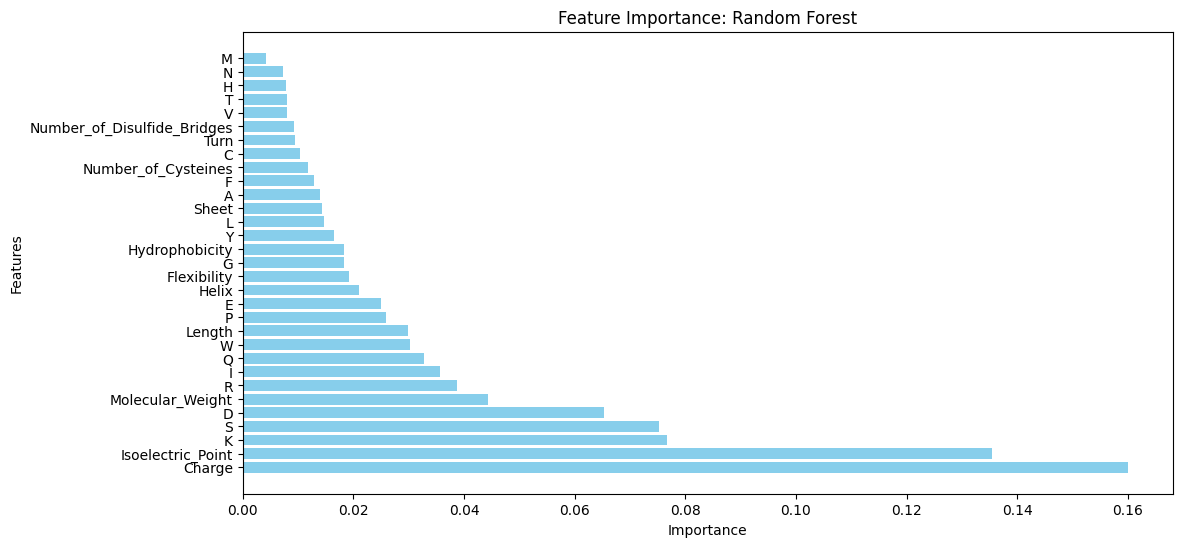

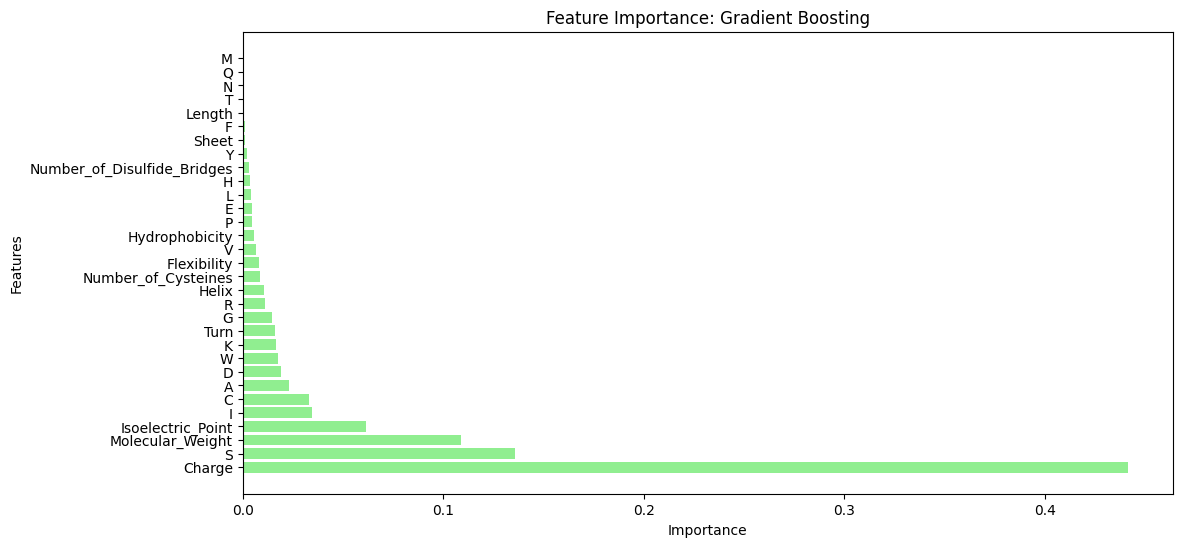

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [16]:
import numpy as np
import joblib
import lime
from lime.lime_tabular import LimeTabularExplainer
from Bio.SeqUtils import molecular_weight
from Bio.Seq import Seq
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

# Load trained models
rf_model = joblib.load('/content/drive/MyDrive/EC/EC imbalance/top3_models/random_forest_model.pkl')
gb_model = joblib.load('/content/drive/MyDrive/EC/EC imbalance/gradient_boosting_best_model.pkl')
ada_model = joblib.load('/content/drive/MyDrive/EC/EC imbalance/top3_models/adaboost_model.pkl')

# Feature calculation functions
def calculate_charge(sequence):
    positive = sequence.count('K') + sequence.count('R') + sequence.count('H')
    negative = sequence.count('D') + sequence.count('E')
    return positive - negative

def calculate_hydrophobicity(sequence):
    hydrophobic_residues = 'AVILMFYW'
    return sum(sequence.count(aa) for aa in hydrophobic_residues)

def calculate_molecular_weight(sequence):
    return molecular_weight(Seq(sequence), seq_type='protein')

def calculate_number_of_cysteines(sequence):
    return sequence.count('C')

def calculate_number_of_disulfide_bridges(sequence):
    return calculate_number_of_cysteines(sequence) // 2

def calculate_isoelectric_point(sequence):
    pKa_acidic = {'D':3.9, 'E':4.25}
    pKa_basic = {'K':10.5, 'R':12.5, 'H':6.0}
    acidic_count = sum(sequence.count(aa) for aa in pKa_acidic)
    basic_count = sum(sequence.count(aa) for aa in pKa_basic)
    if acidic_count + basic_count == 0:
        return 7.0
    total_charge_pI = sum(pKa_acidic[aa]*sequence.count(aa) for aa in pKa_acidic) + sum(pKa_basic[aa]*sequence.count(aa) for aa in pKa_basic)
    return total_charge_pI / (acidic_count + basic_count)

def amino_acid_composition(sequence):
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    total = len(sequence)
    return {aa: (sequence.count(aa) / total * 100 if total > 0 else 0) for aa in amino_acids}

def secondary_structure_features(sequence):
    helix_aa = 'ALIVMFYW'
    sheet_aa = 'FYW'
    turn_aa = 'GP'
    helix = sum(sequence.count(aa) for aa in helix_aa)
    sheet = sum(sequence.count(aa) for aa in sheet_aa)
    turn = sum(sequence.count(aa) for aa in turn_aa)
    flexibility = helix / len(sequence) if len(sequence) > 0 else 0
    return helix, turn, sheet, flexibility

# Load feature columns from training set or fallback list
X_train_cols = ['Length', 'Charge', 'Hydrophobicity', 'Molecular_Weight',
                'Number_of_Cysteines', 'Number_of_Disulfide_Bridges', 'Isoelectric_Point',
                'Helix', 'Turn', 'Sheet', 'Flexibility'] + list('ACDEFGHIKLMNPQRSTVWY')
feature_columns_for_prediction = X_train_cols

# Helper function to calculate all features for a sequence
def calc_features_dict(seq):
    features = {
        'Length': len(seq),
        'Charge': calculate_charge(seq),
        'Hydrophobicity': calculate_hydrophobicity(seq),
        'Molecular_Weight': calculate_molecular_weight(seq),
        'Number_of_Cysteines': calculate_number_of_cysteines(seq),
        'Number_of_Disulfide_Bridges': calculate_number_of_disulfide_bridges(seq),
        'Isoelectric_Point': calculate_isoelectric_point(seq),
    }
    features.update(amino_acid_composition(seq))
    helix, turn, sheet, flexibility = secondary_structure_features(seq)
    features.update({'Helix': helix, 'Turn': turn, 'Sheet': sheet, 'Flexibility': flexibility})
    return features

# Function to prepare features for LIME
def prepare_features(seq):
    features = calc_features_dict(seq)
    feature_vector = np.array([features.get(col, 0) for col in feature_columns_for_prediction])
    return feature_vector

# LIME Explainer
def explain_with_lime(sequence):
    # Prepare feature vector for input sequence
    feature_vector = prepare_features(sequence).reshape(1, -1)

    # LIME Tabular Explainer
    explainer = LimeTabularExplainer(
        training_data=np.array([prepare_features(seq) for seq in ["KKIRVRLSA", "SGLGCNVLRRY"]]), # Example training data
        feature_names=feature_columns_for_prediction,
        class_names=['Inactive', 'Active'],
        mode='classification'
    )

    # Explain prediction for the given sequence
    explanation = explainer.explain_instance(feature_vector[0], rf_model.predict_proba)

    # Show explanation
    explanation.show_in_notebook()

# Function to classify peptide and provide LIME explanation
def on_button_click(b):
    sequence_input = sequence_text.value  # Get the sequence input
    result = classify_peptide(sequence_input)

    # Display results
    output_text.value = f"Results for Sequence: {sequence_input}\n" + \
                        f"RF Probability: {result['RF_Prob']}\n" + \
                        f"GB Probability: {result['GB_Prob']}\n" + \
                        f"AdaBoost Probability: {result['Ada_Prob']}\n" + \
                        f"Is Active: {result['Active']}\n\n" + \
                        f"Feature Importance (Random Forest):\n{result['Importance']['RF Importance']}\n\n" + \
                        f"Feature Importance (Gradient Boosting):\n{result['Importance']['GB Importance']}\n\n" + \
                        f"Feature Values (for explanation):\n{result['Features']}"

    # Plotting which features influenced the classification
    plot_feature_explanation(result)

    # Show LIME explanation
    explain_with_lime(sequence_input)

# Plot Feature Explanation (why active/inactive)
def plot_feature_explanation(result):
    features = result['Features']
    importance = result['Importance']

    # Plot the top features with the highest importance
    rf_features = importance['RF Importance']
    gb_features = importance['GB Importance']

    # Sort by importance
    rf_sorted = sorted(rf_features.items(), key=lambda x: x[1], reverse=True)
    gb_sorted = sorted(gb_features.items(), key=lambda x: x[1], reverse=True)

    rf_labels, rf_vals = zip(*rf_sorted)
    gb_labels, gb_vals = zip(*gb_sorted)

    # Plot RF importance
    plt.figure(figsize=(12, 6))
    plt.barh(rf_labels, rf_vals, color='skyblue', label='Random Forest')
    plt.title("Feature Importance: Random Forest")
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.show()

    # Plot GB importance
    plt.figure(figsize=(12, 6))
    plt.barh(gb_labels, gb_vals, color='lightgreen', label='Gradient Boosting')
    plt.title("Feature Importance: Gradient Boosting")
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.show()

# Create input box for peptide sequence
sequence_text = widgets.Text(
    description="Sequence: ",
    placeholder="Enter sequence here (no spaces)"
)

# Create output area for result display
output_text = widgets.Textarea(
    description="Prediction Results: ",
    disabled=True,
    layout=widgets.Layout(width="500px", height="300px")
)

# Create button to trigger classification
button = widgets.Button(description="Classify Peptide")
button.on_click(on_button_click)

# Display input box, button, and output
display(sequence_text, button, output_text)